# MILP es mucho más útil que LP

A estas alturas ya habéis escuchado que los problemas LP se pueden resolver en tiempo polinomial, mientras que los problemas MILP no. De hecho, MILP es un problema NP-duro. Esto podría parecer una limitación o un inconveniente, pero en realidad está estrechamente relacionado con la categoría de problemas que se pueden representar en cada categoría.
 
*Usando MILP se pueden representar una gran cantidad de problemas para los que no se conoce una solución polinomial.*

A modo de ejemplo, mostramos que introducir una variable binaria auxiliar permite optimizar sobre una región factible no convexa.


## Regiones no convexas

En programación lineal *con variables reales*, *la región factible siempre es convexa*.

La programación lineal con variables mixtas (MILP) permite representar regiones no convexas.
Compara estas dos regiones
$$
\begin{split}
\text{Max: } & x + y \\
 \text{Such that: } & \max\{y-x,y+x-2\} \leq 0\\
  & 0 \leq x \leq 2 \\
  & 0 \leq y \leq 2
\end{split}
\quad
\begin{split}
\text{Max: } & x + y \\
 \text{Such that: } & \min\{y-x,y+x-2\} \leq 0\\
  & 0 \leq x \leq 2 \\
  & 0 \leq y \leq 2
\end{split}
$$


En el problema de la izquierda, la restricción $\max\{y-x,y+x-2\} \leq 0$ es equivalente a dos restricciones:

 - $y-x \leq 0$
 - $y+x-2 \leq 0$
 
Es así porque es lo mismo decir:

 - el máximo entre A y B es menor que C
 - tanto A como B son menores que C

En el problema de la derecha, la restricción $\min\{y-x,y+x-2\} \leq 0$ no es equivalente a la concatenación de dos restricciones lineales.
De hecho, no se puede expresar apilando restricciones lineales de ninguna forma posible, porque *la región factible no es convexa*.

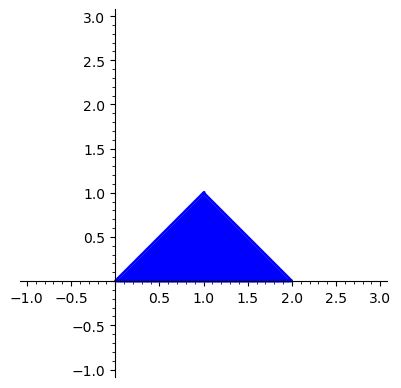

In [1]:
var('x y')
xmin, xmax = -1,3
ymin, ymax = -1,3
restricciones = [x<=2,x>=0,y>=0, y+x-2<=0, y-x<=0]
(region_plot(restricciones,
             (x, xmin, xmax), 
             (y, ymin, ymax),
             borderwidth=2,
             bordercol='blue',
             plot_points=300)
).show()

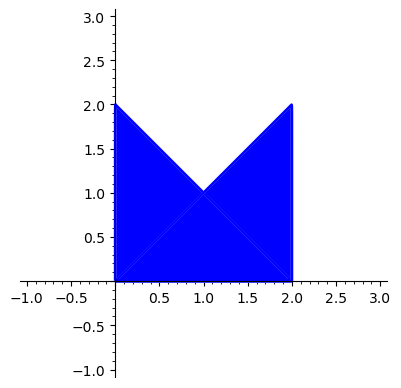

In [2]:
var('x y')
xmin, xmax = -1,3
ymin, ymax = -1,3
restricciones = [x<=2,x>=0,y>=0]
(region_plot(restricciones+ [y+x-2<=0],
             (x, xmin, xmax), 
             (y, ymin, ymax),
             borderwidth=2,
             bordercol='blue',
             plot_points=300) +
 region_plot(restricciones + [y-x<=0],
             (x, xmin, xmax), 
             (y, ymin, ymax),
             borderwidth=2,
             bordercol='blue',
             plot_points=300)
).show()

Resolver el primer problema, con la región convexa, es fácil y no trae sorpresas. Basta con reemplazar el mínimo de dos condiciones lineales por las dos restricciones por separado.

$$
\begin{split}
\text{Max: } & x + y \\
 \text{Such that: } & \max\{y-x,y+x-2\} \leq 0\\
  & 0 \leq x \leq 2 \\
  & 0 \leq y \leq 2
\end{split}\quad\Leftrightarrow\quad
\begin{split}
\text{Max: } & x + y \\
 \text{Such that: } & y-x \leq 0\\
  & y+x-2 \leq 0\\
  & 0 \leq x \leq 2 \\
  & 0 \leq y \leq 2
\end{split}
$$

In [3]:
p = MixedIntegerLinearProgram()
v = p.new_variable(real=True, nonnegative=True)
x, y = v['x'], v['y']
M=100
p.add_constraint(x<=2)
p.add_constraint(y<=2)
p.add_constraint(y-x <= 0)
p.add_constraint(y+x-2<=0)
p.set_objective(y)
print(p.solve())
print(p.get_values(x), p.get_values(y))

1.0
1.0 1.0


Aunque todas las variables que nos interesan sean reales, no podemos optimizar sobre la región no convexa usando LP:

$$
\begin{split}
\text{Max: } & x + y \\
 \text{Such that: } & \min\{y-x,y+x-2\} \leq 0\\
  & 0 \leq x \leq 2 \\
  & 0 \leq y \leq 2
\end{split}
$$

Sin embargo, introduciendo **una variable binaria ``a``**, podemos reescribir $\min\{y-x,y+x-2\} \leq 0$ como dos restricciones:

 - $y-x<=aM$
 - $y+x-2<=(1-a)M$

donde M es *un número muy grande*.

*¿Por qué funciona?*

 - Si a vale 1, la primera desigualdad dice que y-x es menor que un número muy grande, que es automático. Pero la segunda desigualdad hay que cumplirla: y+x-2<=0.
 - Si a vale 0, la segunda desigualdad dice que y+x-2 es menor que un número muy grande, que es automático. Pero la primera desigualdad hay que cumplirla: y-x<=0.

Así que si dejamos que a valga 0 ó 1 libremente, conseguimos decir que es necesario cumplir una de las dos restricciones, pero no es imprescindible cumplir las dos restricciones.

In [4]:
p = MixedIntegerLinearProgram()
v = p.new_variable(real=True, nonnegative=True)
a = p.new_variable(binary=True)
x, y = v['x'], v['y']
a0 = a[0]
M=100
p.add_constraint(x<=2)
p.add_constraint(y<=2)
p.add_constraint(y-x <= a0*M)
p.add_constraint(y+x-2<=(1-a0)*M)
p.set_objective(y)
print(p.solve())
print(p.get_values(x), p.get_values(y))

2.0
0.0 2.0


Podemos usar un truco sencillo para maximizar una función objetivo como $\min\{y-2x+2,y+2x-2\}$:
- Introducimos una variable **``o``** que representa el objetivo (maximizar **``o``**)
- Queremos que **``o``** sea menor que $\min\{y-2x+2,y+2x-2\}$. Introducimos dos restricciones que dicen que:
   - **o** es menor que y-2x+2
   - **o** que es menor que y+2x-2

In [5]:
p = MixedIntegerLinearProgram()
v = p.new_variable(real=True, nonnegative=True)
a = p.new_variable(binary=True)
x, y = v['x'], v['y']
o = v['o']
a0, a1 = a[0], a[1]
M=100
p.add_constraint(x<=2)
p.add_constraint(y<=2)
p.add_constraint(y-x <= a0*M)
p.add_constraint(y+x-2<=(1-a0)*M)
p.add_constraint(o <= y-2*x+2)
p.add_constraint(o <= y+2*x-2)
p.set_objective(o)
print(p.solve())
print(p.get_values(x), p.get_values(y))

1.0
1.0 1.0



El truco similar para maximizar una función máximo necesita una variable binaria:

Por ejemplo, para $\max\{y-2x+2,y+2x-2\}$.

- Introducimos una variable **``o``** que representa el objetivo (maximizar ``o``)
- Queremos que **``o``** sea menor que $\max\{y-2x+2,y+2x-2\}$:
    - Introducimos una variable binaria auxiliar $a_1$, y un número M muy grande.
    - Introducimos dos restricciones que dicen que **o** es menor que y-2x+2 *ó que **o** es menor que* y+2x-2:
        - $o <= y-2x+2 + a_1 M$
        - $o <= y+2x-2 + (1-a_1) M$
    - De este modo, es suficiente con que **o** sea menor que una de las dos funciones, $y-2x+2$, o $y+2x-2$.
        - Si $a_1$ vale 1, la primera restricción es automática, pero la segunda no lo es.
        - Si $a_1$ vale 0, la segunda restricción es automática, pero la primera no lo es.

In [6]:
p = MixedIntegerLinearProgram()
v = p.new_variable(real=True, nonnegative=True)
a = p.new_variable(binary=True)
x, y = v['x'], v['y']
o = v['o']
a0, a1 = a[0], a[1]
M=100
p.add_constraint(x<=2)
p.add_constraint(y<=2)
p.add_constraint(y-x <= a0*M)
p.add_constraint(y+x-2<=(1-a0)*M)
p.add_constraint(o <= y-2*x+2 + a1*M)
p.add_constraint(o <= y+2*x-2 + (1-a1)*M)
p.set_objective(o)
print(p.solve())
print(p.get_values(x), p.get_values(y))

4.0
2.0 2.0
